In [107]:
import os
import sys
import random
import json
import collections
import itertools

import pandas as pd
import numpy as np
import scipy        
import statsmodels
from sklearn.model_selection import train_test_split

from tqdm import trange, tqdm_notebook as tqdm
from matplotlib import pyplot as plt
import seaborn as sns

import pickle
import torch
import torchtext
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import time
import torch.optim as optim
from torchtext.data import Field, RawField
from torchtext.data import Dataset, TabularDataset
from torchtext.data import Iterator

from annoy import AnnoyIndex

from MulticoreTSNE import MulticoreTSNE as TSNE

%matplotlib inline

pd.options.display.max_columns = 999

sns.set()

plt.rcParams["figure.figsize"] = (10,7)

In [108]:
os.getcwd()

'/home/boris/study/UT study/ACM Sigmod/sigmod/notebooks'

In [109]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [110]:
from sigmod_src.utils import read_json, pprint_json, path_from_spec_id, get_vector_for_spec_id
from sigmod_src.data.embedding import Embedder, EmbeddingBagEmbedder, LSTMEmbedder

# Load data

In [111]:
MED_LABELS_PATH = '../data/raw/sigmod_medium_labelled_dataset.csv'
LG_LABELS_PATH = '../data/interim/large_labelled_dataset_disjoint.csv'

In [112]:
med_labels_df = pd.read_csv(MED_LABELS_PATH)
lg_labels_df = pd.read_csv(LG_LABELS_PATH)

In [113]:
med_labels_df.shape, lg_labels_df.shape

((46665, 3), (250986, 3))

In [114]:
med_labels_df.head()

,left_spec_id,right_spec_id,label
0,www.garricks.com.au//31,www.ebay.com//53278,1
1,www.ebay.com//58782,www.ebay.com//24817,0
2,www.ebay.com//58782,www.ebay.com//43019,0
3,www.ebay.com//42055,www.ebay.com//54403,0
4,www.ebay.com//44280,buy.net//6145,0


In [115]:
lg_labels_df.head()

,left_spec_id,right_spec_id,label
0,www.pricedekho.com//1053,www.ebay.com//58716,1.0
1,www.ebay.com//60064,www.ebay.com//54572,1.0
2,www.ebay.com//47074,www.ebay.com//55373,1.0
3,www.ebay.com//48188,www.ebay.com//44391,1.0
4,www.ebay.com//54736,www.ebay.com//58806,1.0


# Load specs df

In [116]:
specs_df = pd.read_csv('../data/processed/specs_preprocessed.csv')
# specs_df.index=  specs_df.spec_id
specs_df.shape

(29771, 7)

In [117]:
specs_df[specs_df.page_title.isnull()]

,spec_id,page_title,all_text,page_title_stem,all_text_stem,brand,site


In [118]:
specs_df.head()

,spec_id,page_title,all_text,page_title_stem,all_text_stem,brand,site
0,www.ebay.com//57656,canon powershot elph 110 hs 16 1 mp,canon elph 110 hs 16 1 mp canon manufacturer r...,canon powershot elph 110 hs 16 1 mp,canon elph 110 hs 16 1 mp canon manufactur ref...,canon,www.ebay.com
1,www.ebay.com//60583,canon rebel 2000 35 mm great case instruction ...,canon rebel 2000 35 mm great case instruction ...,canon rebel 2000 35 mm great case instruct boo...,canon rebel 2000 35 mm great case instruct boo...,canon,www.ebay.com
2,www.ebay.com//60440,canon eos rebel t3i 18 55mm 75 300mm iii lens ...,canon eos rebel 18 55mm 75 300mm iii lens kit ...,canon eo rebel t3i 18 55mm 75 300mm iii len ki...,canon eo rebel 18 55mm 75 300mm iii len kit us...,canon,www.ebay.com
3,www.ebay.com//24139,ge c1033 10 1 mp 3x zoom 2 4 lcd,ge c1033 10 1 mp 3x zoom 2 4 ge unused undamag...,ge c1033 10 1 mp 3x zoom 2 4 lcd,ge c1033 10 1 mp 3x zoom 2 4 ge unus undamag o...,NaN,www.ebay.com
4,www.ebay.com//54903,vivitar clip shot 1 1 mp,vivitar clip shot 1 1 mp vivitar unused undama...,vivitar clip shot 1 1 mp,vivitar clip shot 1 1 mp vivitar unus undamag ...,vivitar,www.ebay.com


# Classes df

In [119]:
classes_df = pd.read_csv('../data/interim/classes.csv')
classes_df.head()

,spec_id,class_
0,buy.net//5641,0
1,www.ebay.com//58588,0
2,www.gosale.com//849,0
3,www.price-hunt.com//9794,0
4,buy.net//5698,1


In [120]:
classes_df.shape

(908, 2)

In [121]:
classes_df.class_.value_counts()

6     178
2     130
11     95
4      91
13     80
7      78
9      57
1      55
12     16
24     14
10     14
19     11
20      9
5       9
23      9
3       9
17      7
0       6
14      5
16      5
18      5
15      4
21      4
26      4
25      3
28      2
8       2
22      2
27      2
29      2
Name: class_, dtype: int64

### Add classes to specs

In [122]:
specs_df = specs_df.merge(classes_df, how='left')
specs_df.head()

,spec_id,page_title,all_text,page_title_stem,all_text_stem,brand,site,class_
0,www.ebay.com//57656,canon powershot elph 110 hs 16 1 mp,canon elph 110 hs 16 1 mp canon manufacturer r...,canon powershot elph 110 hs 16 1 mp,canon elph 110 hs 16 1 mp canon manufactur ref...,canon,www.ebay.com,NaN
1,www.ebay.com//60583,canon rebel 2000 35 mm great case instruction ...,canon rebel 2000 35 mm great case instruction ...,canon rebel 2000 35 mm great case instruct boo...,canon rebel 2000 35 mm great case instruct boo...,canon,www.ebay.com,NaN
2,www.ebay.com//60440,canon eos rebel t3i 18 55mm 75 300mm iii lens ...,canon eos rebel 18 55mm 75 300mm iii lens kit ...,canon eo rebel t3i 18 55mm 75 300mm iii len ki...,canon eo rebel 18 55mm 75 300mm iii len kit us...,canon,www.ebay.com,NaN
3,www.ebay.com//24139,ge c1033 10 1 mp 3x zoom 2 4 lcd,ge c1033 10 1 mp 3x zoom 2 4 ge unused undamag...,ge c1033 10 1 mp 3x zoom 2 4 lcd,ge c1033 10 1 mp 3x zoom 2 4 ge unus undamag o...,NaN,www.ebay.com,NaN
4,www.ebay.com//54903,vivitar clip shot 1 1 mp,vivitar clip shot 1 1 mp vivitar unused undama...,vivitar clip shot 1 1 mp,vivitar clip shot 1 1 mp vivitar unus undamag ...,vivitar,www.ebay.com,NaN


In [123]:
class_vcounts = specs_df.class_.value_counts()
class_vcounts

6.0     178
2.0     130
11.0     95
4.0      91
13.0     80
7.0      78
9.0      57
1.0      55
12.0     16
10.0     14
24.0     14
19.0     11
5.0       9
20.0      9
3.0       9
23.0      9
17.0      7
0.0       6
16.0      5
14.0      5
18.0      5
26.0      4
21.0      4
15.0      4
25.0      3
8.0       2
22.0      2
28.0      2
27.0      2
29.0      2
Name: class_, dtype: int64

In [124]:
bad_classes = list(class_vcounts[class_vcounts<2].index)
bad_classes

[]

In [125]:
specs_df.shape

(29771, 8)

In [126]:
specs_df = specs_df[~specs_df.class_.isin(bad_classes)]
specs_df.shape

(29771, 8)

In [127]:
labelled_specs_df = specs_df[~specs_df.class_.isnull()].copy()
labelled_specs_df.shape

(908, 8)

In [128]:
labelled_specs_df.to_csv('../data/interim/specs_df_labelled.csv', index=None)

In [129]:
labelled_specs_df['spec_idx'] = range(len(labelled_specs_df))
labelled_specs_df.head()

,spec_id,page_title,all_text,page_title_stem,all_text_stem,brand,site,class_,spec_idx
29,www.ebay.com//55555,nikon d800 36 3 mp body,nikon 36 3 mp body nikon may signs cosmetic we...,nikon d800 36 3 mp bodi,nikon 36 3 mp bodi nikon may sign cosmet wear ...,nikon,www.ebay.com,13.0,0
40,www.ebay.com//46983,nikon d90 12 3 mp kit w vr 18 105 mm lens,nikon d90 12 3 mp kit w vr 18 105 mm lens niko...,nikon d90 12 3 mp kit w vr 18 105 mm len,nikon d90 12 3 mp kit w vr 18 105 mm len nikon...,nikon,www.ebay.com,4.0,1
45,www.ebay.com//55066,nikon d90 12 3 mp w af 18 200mm lens,nikon d90 12 3 mp w af 18 200mm lens nikon len...,nikon d90 12 3 mp w af 18 200mm len,nikon d90 12 3 mp w af 18 200mm len nikon len ...,nikon,www.ebay.com,4.0,2
46,www.ebay.com//41954,canon eos 20d 8 2 mp body,canon eos 20d 8 2 mp body canon extra battery ...,canon eo 20d 8 2 mp bodi,canon eo 20d 8 2 mp bodi canon extra batteri m...,canon,www.ebay.com,10.0,3
56,www.ebay.com//45818,canon eos 5d mark ii excellent japan 2882,canon eos 5d mark ii excellent japan never min...,canon eo 5d mark ii excel japan 2882,canon eo 5d mark ii excel japan never minim si...,canon,www.ebay.com,11.0,4


# Obtain train/val split

In [219]:
INTERIM_PATH = '../data/interim/'
TRAIN_PATH = 'specs_train.csv'
VAL_PATH = 'specs_val.csv'

classes = labelled_specs_df.class_.unique()
val_classes = np.random.choice(classes, 5)

labelled_specs_train = labelled_specs_df[~labelled_specs_df.class_.isin(val_classes)]
labelled_specs_val = labelled_specs_df[labelled_specs_df.class_.isin(val_classes)]

labelled_specs_train.to_csv(os.path.join(INTERIM_PATH, TRAIN_PATH), index=None)
labelled_specs_val.to_csv(os.path.join(INTERIM_PATH, VAL_PATH), index=None)

labelled_specs_train.shape, labelled_specs_val.shape

((746, 9), (162, 9))

In [232]:
def tokenize(text):
    return text.split(' ')

text_field = Field(sequential=True, tokenize=tokenize, lower=True)
label_field = Field(sequential=False, use_vocab=False, is_target=True, dtype=torch.uint8, tokenize=None, preprocessing=lambda x: int(float(x)))

In [233]:
%%time
datafields = [("spec_id", None),
              ("page_title", None),
              ("all_text", None),
              ("page_title_stem", text_field),
              ("all_text_stem", None),
                  ("brand", None),
                  ("site", None),
             ('class_', label_field)]

full_dataset = TabularDataset.splits(
        path="../data/processed/", # the root directory where the data lies
        train='specs_preprocessed.csv',
        format='csv',
        skip_header=True, # if your csv header has a header, make sure to pass this to ensure it doesn't get proceesed as data!
        fields=datafields)

train_dataset, val_dataset = TabularDataset.splits(
    path=INTERIM_PATH, # the root directory where the data lies
    train=TRAIN_PATH,
    test=VAL_PATH,
    format='csv',
    skip_header=True, # if your csv header has a header, make sure to pass this to ensure it doesn't get proceesed as data!
    fields=datafields)

full_dataset = full_dataset[0]

CPU times: user 623 ms, sys: 10.8 ms, total: 634 ms
Wall time: 633 ms


In [234]:
train_labelled_df = pd.read_csv(os.path.join(INTERIM_PATH, TRAIN_PATH))
train_labelled_df['spec_idx'] = range(len(train_labelled_df))

# train_class_lookup = train_labelled_df[~train_labelled_df.class_.isnull()].set_index('spec_idx').to_dict()['class_']
# train_spec_lookup = train_labelled_df.groupby(['class_'])['spec_idx'].agg(list).to_dict()

In [235]:
val_labelled_df = pd.read_csv(os.path.join(INTERIM_PATH, VAL_PATH))
val_labelled_df['spec_idx'] = range(len(val_labelled_df))

# val_class_lookup = val_labelled_df[~val_labelled_df.class_.isnull()].set_index('spec_idx').to_dict()['class_']
# val_spec_lookup = val_labelled_df.groupby(['class_'])['spec_idx'].agg(list).to_dict()

In [236]:
%%time
text_field.build_vocab(full_dataset)

CPU times: user 171 ms, sys: 887 µs, total: 172 ms
Wall time: 170 ms


## Quick checks

In [237]:
specs_df.head(1)

,spec_id,page_title,all_text,page_title_stem,all_text_stem,brand,site,class_
0,www.ebay.com//57656,canon powershot elph 110 hs 16 1 mp,canon elph 110 hs 16 1 mp canon manufacturer r...,canon powershot elph 110 hs 16 1 mp,canon elph 110 hs 16 1 mp canon manufactur ref...,canon,www.ebay.com,NaN


In [238]:
full_dataset.examples[0].__dict__

{'page_title_stem': ['canon',
  'powershot',
  'elph',
  '110',
  'hs',
  '16',
  '1',
  'mp']}

In [239]:
train_labelled_df.head(1)

,spec_id,page_title,all_text,page_title_stem,all_text_stem,brand,site,class_,spec_idx
0,www.ebay.com//55555,nikon d800 36 3 mp body,nikon 36 3 mp body nikon may signs cosmetic we...,nikon d800 36 3 mp bodi,nikon 36 3 mp bodi nikon may sign cosmet wear ...,nikon,www.ebay.com,13.0,0


In [240]:
train_dataset.examples[0].__dict__

{'class_': 13, 'page_title_stem': ['nikon', 'd800', '36', '3', 'mp', 'bodi']}

In [241]:
label_field.numericalize([train_dataset.examples[0].class_])

tensor([13], dtype=torch.uint8)

In [242]:
val_labelled_df.head(1)

,spec_id,page_title,all_text,page_title_stem,all_text_stem,brand,site,class_,spec_idx
0,www.ebay.com//25152,nikon d7000 16 2 megapixel dx body great 23228,nikon d7000 16 2 megapixel dx body great nikon...,nikon d7000 16 2 megapixel dx bodi great 23228,nikon d7000 16 2 megapixel dx bodi great nikon...,nikon,www.ebay.com,2.0,0


In [243]:
val_dataset.examples[0].__dict__

{'class_': 2,
 'page_title_stem': ['nikon',
  'd7000',
  '16',
  '2',
  'megapixel',
  'dx',
  'bodi',
  'great',
  '23228']}

# Batch sampler

Sampler that returns indices `n_samples` of `n_classes` in each batch.

In [244]:
from torch.utils.data.sampler import BatchSampler

In [245]:
# src: https://github.com/adambielski/siamese-triplet/blob/master/datasets.py
class BalancedBatchSampler(BatchSampler):
    """
    BatchSampler - from a MNIST-like dataset, samples n_classes and within these classes samples n_samples.
    Returns batches of size n_classes * n_samples
    """

    def __init__(self, labels, n_classes, n_samples):
        self.labels = labels
        self.labels_set = list(set(self.labels.numpy()))
        self.label_to_indices = {label: np.where(self.labels.numpy() == label)[0]
                                 for label in self.labels_set}
        for l in self.labels_set:
            np.random.shuffle(self.label_to_indices[l])
        self.used_label_indices_count = {label: 0 for label in self.labels_set}
        self.count = 0
        self.n_classes = n_classes
        self.n_samples = n_samples
        self.n_dataset = len(self.labels)
        self.batch_size = self.n_samples * self.n_classes

    def __iter__(self):
        self.count = 0
        while self.count + self.batch_size < self.n_dataset:
            classes = np.random.choice(self.labels_set, self.n_classes, replace=False)
            indices = []
            for class_ in classes:
                indices.extend(self.label_to_indices[class_][
                               self.used_label_indices_count[class_]:self.used_label_indices_count[
                                                                         class_] + self.n_samples])
                self.used_label_indices_count[class_] += self.n_samples
                if self.used_label_indices_count[class_] + self.n_samples > len(self.label_to_indices[class_]):
                    np.random.shuffle(self.label_to_indices[class_])
                    self.used_label_indices_count[class_] = 0
            yield indices
            self.count += self.n_classes * self.n_samples

    def __len__(self):
        return self.n_dataset // self.batch_size

In [246]:
def get_batch_tensor(dataset, sampler, text_field, text_field_name, label_field, label_field_name='class_'):
    for indices in iter(sampler):
        examples = [dataset[i] for i in indices]
        texts = [getattr(ex, text_field_name) for ex in examples]
        labels = label_field.numericalize([getattr(ex, label_field_name) for ex in examples])
        tensor = text_field.numericalize(text_field.pad(texts))        
        yield tensor, labels

#### Test batch sampler

In [247]:
# Select 2 random classes, 3 samples of each
sampler = BalancedBatchSampler(torch.Tensor(train_labelled_df.class_.values), 2, 1)

indices = next(iter(sampler))

rows = train_labelled_df.iloc[indices]

print('Class distribution\n', rows.class_.value_counts())

rows

Class distribution
 22.0    1
3.0     1
Name: class_, dtype: int64


,spec_id,page_title,all_text,page_title_stem,all_text_stem,brand,site,class_,spec_idx
609,www.priceme.co.nz//2346,nikon coolpix s01 mini zealand prices priceme,nikon coolpix s01 mini zealand prices priceme ...,nikon coolpix s01 mini zealand price pricem,nikon coolpix s01 mini zealand price pricem nu...,nikon,www.priceme.co.nz,3.0,609
239,www.ebay.com//46830,canon eos 60da astrophotography,canon eos 60da astrophotography canon unused u...,canon eo 60da astrophotographi,canon eo 60da astrophotographi canon unus unda...,canon,www.ebay.com,22.0,239


In [248]:
next(iter(get_batch_tensor(train_dataset, sampler, text_field, 'page_title_stem', label_field)))

(tensor([[  7,  43],
         [239,  51],
         [130,  38],
         [ 19,  28],
         [  2,  94],
         [ 18,   1],
         [ 27,   1],
         [129,   1],
         [ 68,   1],
         [154,   1],
         [ 24,   1],
         [ 58,   1],
         [245,   1],
         [166,   1]]), tensor([ 1, 28], dtype=torch.uint8))

# Hyperparams

In [416]:
text_field_name = 'page_title_stem'
batch_n_classes = 10
batch_n_samples = 10
emb_dim = 200
hidden_dim = 200
num_linear = 3
margin = 0.1

# Batch generators

In [417]:
train_batch_sampler = BalancedBatchSampler(torch.Tensor(train_labelled_df.class_.values), batch_n_classes, batch_n_samples)


val_batch_sampler = BalancedBatchSampler(torch.Tensor(val_labelled_df.class_.values), min(batch_n_classes, len(val_labelled_df.class_.unique())), batch_n_samples)

train_iterator = iter(get_batch_tensor(train_dataset, train_batch_sampler, text_field, text_field_name, label_field))
val_iterator = iter(get_batch_tensor(val_dataset, val_batch_sampler, text_field, text_field_name, label_field))

def get_train_iterator():
    return iter(get_batch_tensor(train_dataset, train_batch_sampler, text_field, text_field_name, label_field))

def get_val_iterator():
    return iter(get_batch_tensor(val_dataset, val_batch_sampler, text_field, text_field_name, label_field))

# Model

In [418]:
model = EmbeddingBagEmbedder(text_field, hidden_dim, emb_dim=emb_dim, num_linear=num_linear)

# model = LSTMEmbedder(text_field,
#                      lstm_dim=300,
#                      emb_dim=emb_dim,
#                      hidden_dim=hidden_dim,
#                      num_linear=num_linear,
#                      num_lstm=1
#                      )
model

EmbeddingBagEmbedder(
  (relu): ReLU()
  (embedding_bag): EmbeddingBag(9304, 200, mode=mean)
  (linear_layers): ModuleList(
    (0): Sequential(
      (0): Linear(in_features=200, out_features=200, bias=True)
      (1): Dropout(p=0.05, inplace=False)
    )
    (1): Sequential(
      (0): Linear(in_features=200, out_features=200, bias=True)
      (1): Dropout(p=0.05, inplace=False)
    )
    (2): Sequential(
      (0): Linear(in_features=200, out_features=200, bias=True)
      (1): Dropout(p=0.05, inplace=False)
    )
    (3): Sequential(
      (0): Linear(in_features=200, out_features=200, bias=True)
    )
  )
)

# Online triplet loss

In [419]:
from online_triplet_loss.losses import batch_hard_triplet_loss

### Tests

Test model

In [420]:
model.infer(['canon eos 20d 8 2 mp', 'nikon eos 20d'])

tensor([[1.6761e-02, 2.6402e-02, 1.3011e-02, 0.0000e+00, 0.0000e+00, 5.8135e-03,
         7.6453e-02, 2.2960e-04, 0.0000e+00, 6.2206e-02, 3.2762e-02, 0.0000e+00,
         0.0000e+00, 4.8882e-02, 0.0000e+00, 0.0000e+00, 7.6331e-02, 9.2813e-02,
         2.2567e-02, 4.4562e-02, 0.0000e+00, 5.0585e-02, 0.0000e+00, 2.2677e-02,
         1.5279e-02, 3.8199e-02, 3.0089e-02, 0.0000e+00, 1.0206e-01, 3.0096e-02,
         0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
         3.3106e-02, 4.6290e-03, 4.1935e-02, 0.0000e+00, 0.0000e+00, 8.0219e-02,
         3.8384e-03, 8.8014e-02, 5.6356e-02, 0.0000e+00, 4.1842e-02, 3.5122e-02,
         6.5823e-02, 2.2587e-02, 0.0000e+00, 7.6116e-02, 0.0000e+00, 0.0000e+00,
         6.6777e-04, 0.0000e+00, 0.0000e+00, 5.3589e-02, 0.0000e+00, 1.9822e-02,
         0.0000e+00, 0.0000e+00, 1.8976e-02, 4.3281e-02, 0.0000e+00, 2.5445e-02,
         4.9522e-02, 0.0000e+00, 2.4649e-02, 3.8715e-02, 1.1563e-02, 0.0000e+00,
         0.0000e+00, 1.2017e

Test loss

In [421]:
batch = next(get_train_iterator())
text_tensor, labels = batch
embeddings = model(text_tensor)

loss = batch_hard_triplet_loss(labels, embeddings, margin=margin)
print('Loss:', loss)
loss.backward()

Loss: tensor(0.1771, grad_fn=<MeanBackward0>)


In [422]:
batch = next(get_val_iterator())
text_tensor, labels = batch
embeddings = model(text_tensor)

loss = batch_hard_triplet_loss(labels, embeddings, margin=margin)
print('Loss:', loss)

Loss: tensor(0.1865, grad_fn=<MeanBackward0>)


# Train

In [423]:
loss_history_train = []
loss_history_val = []

In [424]:
opt = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-4)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(opt, mode='min', patience=3, verbose=True)
epochs = 100
early_stop_patience = 10

In [425]:
validation_batches = []
for i in range(100):
    for batch in get_val_iterator():
        validation_batches.append(batch)
len(validation_batches)

300

In [426]:
%%time

no_improvenment_count = 0
best_val_loss = 9999
for epoch in tqdm(range(1, epochs + 1)):
    model.train()
    
    running_loss = 0
    count_triplets = 0
    
    for batch in get_train_iterator():
        opt.zero_grad()
        
        texts, labels = batch
        embeddings = model(texts)
        loss = batch_hard_triplet_loss(labels, embeddings, margin=margin)
        loss.backward()
        opt.step()
        
        running_loss += loss.data
        count_triplets +=1 

    
    epoch_loss = running_loss / count_triplets
    loss_history_train.append(epoch_loss)
    print('Epoch: {}, Training Loss: {:.4f}'.format(epoch, epoch_loss))
    
    model.eval()
    val_loss = 0
    count_val = 0
    with torch.no_grad():
        for batch in validation_batches:
            texts, labels = batch
            embeddings = model(texts)
            loss = batch_hard_triplet_loss(labels, embeddings, margin=margin)
            val_loss += loss.data
            count_val +=1 
        
        epoch_val_loss = val_loss/count_val
        loss_history_val.append(epoch_val_loss)
        print('val Loss: {:.4f}'.format(epoch_val_loss))
        
    scheduler.step(epoch_val_loss)
    
    # Early stopping
    if epoch_val_loss >= best_val_loss:
        no_improvenment_count += 1
    else:
        best_val_loss = epoch_val_loss
        no_improvenment_count = 0
        
    if no_improvenment_count > early_stop_patience:
        print('Early stopping')
        break
model.eval()

HBox(children=(IntProgress(value=0), HTML(value='')))

Epoch: 1, Training Loss: 0.1447
val Loss: 0.1176
Epoch: 2, Training Loss: 0.1249
val Loss: 0.1159
Epoch: 3, Training Loss: 0.1174
val Loss: 0.1085
Epoch: 4, Training Loss: 0.1124
val Loss: 0.1063
Epoch: 5, Training Loss: 0.1099
val Loss: 0.1055
Epoch: 6, Training Loss: 0.1078
val Loss: 0.1046
Epoch: 7, Training Loss: 0.1062
val Loss: 0.1025
Epoch: 8, Training Loss: 0.1046
val Loss: 0.1023
Epoch: 9, Training Loss: 0.1043
val Loss: 0.1023
Epoch: 10, Training Loss: 0.1037
val Loss: 0.1020
Epoch: 11, Training Loss: 0.1026
val Loss: 0.1021
Epoch: 12, Training Loss: 0.1021
val Loss: 0.1022
Epoch: 13, Training Loss: 0.1017
val Loss: 0.1025
Epoch: 14, Training Loss: 0.1022
val Loss: 0.1026
Epoch    13: reducing learning rate of group 0 to 1.0000e-04.
Epoch: 15, Training Loss: 0.1014
val Loss: 0.1024
Epoch: 16, Training Loss: 0.1014
val Loss: 0.1022
Epoch: 17, Training Loss: 0.1013
val Loss: 0.1021
Epoch: 18, Training Loss: 0.1010
val Loss: 0.1022
Epoch    17: reducing learning rate of group 0 

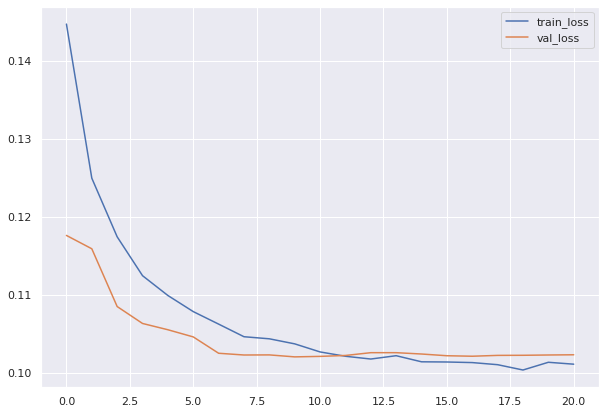

In [427]:
plt.figure()
plt.plot(loss_history_train, label='train_loss')
plt.plot(loss_history_val, label='val_loss')
plt.legend()
plt.show()

In [428]:
model.eval()

EmbeddingBagEmbedder(
  (relu): ReLU()
  (embedding_bag): EmbeddingBag(9304, 200, mode=mean)
  (linear_layers): ModuleList(
    (0): Sequential(
      (0): Linear(in_features=200, out_features=200, bias=True)
      (1): Dropout(p=0.05, inplace=False)
    )
    (1): Sequential(
      (0): Linear(in_features=200, out_features=200, bias=True)
      (1): Dropout(p=0.05, inplace=False)
    )
    (2): Sequential(
      (0): Linear(in_features=200, out_features=200, bias=True)
      (1): Dropout(p=0.05, inplace=False)
    )
    (3): Sequential(
      (0): Linear(in_features=200, out_features=200, bias=True)
    )
  )
)

# Produce train embeddings and TSNE

In [429]:
from sklearn.preprocessing import normalize

In [430]:
def draw_tsne(model, dataset, df, text_field_name='page_title_stem', label=''):
    embeddings = []
    for ex in tqdm(dataset):
        emb = np.array(model(model.text_field.numericalize([getattr(ex, text_field_name)]))[0].data)
        embeddings.append(emb)
    embeddings = normalize(np.array(embeddings))
    
    tsne = TSNE(
        n_components=2,
        metric='cosine',
        n_jobs=3,
        verbose=True,
    )
    
    emb_ld = tsne.fit_transform(embeddings)
    
    labelled_spec_classes = df.class_
    labelled_spec_classes = labelled_spec_classes.reset_index()
    
    emb_tdf = pd.DataFrame(emb_ld)
    emb_tdf = pd.concat([emb_tdf, labelled_spec_classes], axis=1, ignore_index=True)
    emb_tdf.columns = ['x', 'y', 'original_index', 'class_']

    
    
    plt.figure(figsize=(15, 10))
    plt.title(f'TSNE {label}')
    for class_ in emb_tdf['class_'].sort_values().unique():
        class_ld_df = emb_tdf[emb_tdf.class_==class_]
        plt.scatter(class_ld_df.iloc[:, 0], class_ld_df.iloc[:, 1], label=f'class {class_}')

    plt.legend()
    plt.show()

HBox(children=(IntProgress(value=0, max=746), HTML(value='')))

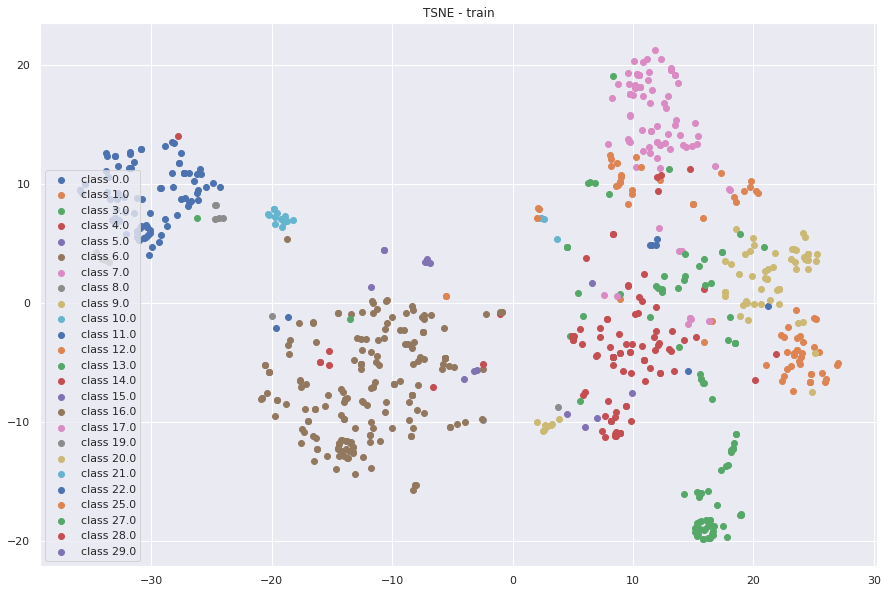

In [431]:
draw_tsne(model, train_dataset, labelled_specs_train, label ='- train')

HBox(children=(IntProgress(value=0, max=162), HTML(value='')))

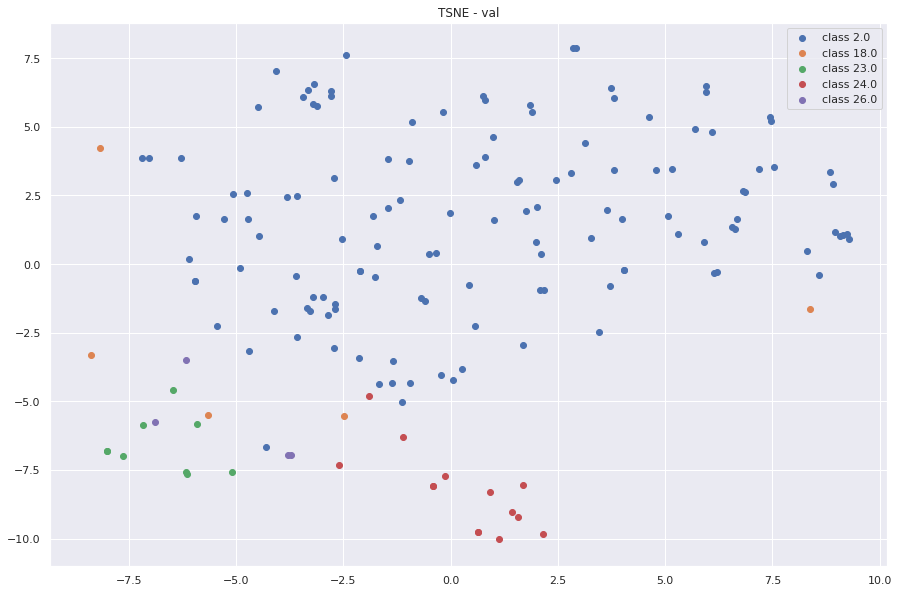

In [432]:
draw_tsne(model, val_dataset, labelled_specs_val, label ='- val')

# Produce whole dataset embeddings

In [433]:
embeddings = []
for ex in tqdm(full_dataset):
    emb = np.array(model(model.text_field.numericalize([ex.page_title_stem]))[0].data)
    embeddings.append(emb)
embeddings = normalize(np.array(embeddings))

HBox(children=(IntProgress(value=0, max=29771), HTML(value='')))

In [434]:
emb_df = pd.DataFrame(embeddings)
emb_df.to_csv('../data/processed/embeddings.csv', index=None)

In [435]:
emb_df = pd.read_csv('../data/processed/embeddings.csv')

In [436]:
emb = Embedder(model, specs_df.spec_id.values, specs_df.all_text_stem.values)

In [437]:
emb.fit(emb_df.values)

In [438]:
emb.lookup_texts('canon eo 20d')

array(['canon eo 20d bodi canon extra batteri may sign cosmet wear fulli oper function intend may floor model store return seller full detail descript imperfect open window tab read moreabout mp 20d',
       'canon eo 20d 8 2mp bodi pleas includ full zip code canon ship store pickup ship anywher ship buyer paypal address ship fee paid may sign cosmet wear fulli oper function intend may floor model store return seller full detail descript imperfect open window tab read moreabout mp 20d none know want pick ship',
       'canon eo 20d 8 2mp bodi canon may sign cosmet wear fulli oper function intend may floor model store return seller full detail descript imperfect open window tab read moreabout mp 20d',
       'canon eo 20d 8 2mp bodi pleas includ full zip code canon ship store pickup ship anywher ship buyer paypal address ship fee paid may sign cosmet wear fulli oper function intend may floor model store return seller full detail descript imperfect open window tab read moreabout mp 20d k

In [439]:
emb.save('../models/embedder')